# Motivation

The CityLearn Challenge 2022 was offered as a NeurIPS competition to "minimise the monetary cost of electricity drawn from the grid and the CO2 emissions when electicity demand is satsified by the grid".

Buildings are responsible for 30% of greenhouse gas emissions, and the use of residential rooftop solar panels is being promoted as a popular way to bring this figure down. This brings with it additional technical challenges: at peak times, the electricity generated may be more than the household's demand (load), while at other times such as at night the solar panel will not be able to meet the demand. Excess electricity can be stored in batteries, but there is an inefficiency associated with both charging and discharging it; at times, it may be more cost- and resource-efficient to rely on the grid and not the battery. This is an unsolved problem at the moment, resulting in higher financial and carbon costs than necessary. The aim of this challenge is to develop a reinforcement learning policy and reward function that while efforts to install more rooftop solar panels are mitigating this, for best performance efficiencies need to be made during the charge and discharge of batteries.

The solution is evaluated by testing it on one year of data for a collection of buildings, and giving it a score composed of the cost relative to if there were no battery, added to the CO2 emissions relative to if there were no battery.

**Observations**
* "Calendar" category: month, day of the week, hour of the day
* "Weather" category: current and predicted future temperature, humidity, diffuse solar irradiance, and direct solar irradiance
* "District" category: rate of carbon emissions of the grid
* "Building" category: temperature and humidity of the building, non-shiftable loads, electricity generated by solar panels, current storage capacity, electricity consumption, current and future electricity grid price, etc.

**Actions**

There are 6 actions, each one taking a continuous value from -1 to 1 representing the proportion of a storage device that should be (dis)charged.

**Reward function**

The default reward function is the electricity consumption from the grid at the current timestep, as a negative value.

**Baselines**

The CityLearn package provides a random policy and a rule-based policy to be used as baselines. We also have the winning solution against which to compare.

Here an additional baseline is developed against which to compare an optimised reinforcement learning model: an agent that takes the same action regardless of inputs.

# Exploring the CityLearn environment

In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

In [21]:
# Initialise CityLearn environment
DATASET_NAME = 'citylearn_challenge_2022_phase_1'
schema = DataSet.get_schema(DATASET_NAME)
env = CityLearnEnv(schema)

In [22]:
from citylearn.base import Environment

**Action space to sample from**

In [23]:
env = CityLearnEnv(schema, central_agent=True)
env.action_space

[Box([-0.78125 -0.78125 -0.78125 -0.78125 -0.78125], [0.78125 0.78125 0.78125 0.78125 0.78125], (5,), float32)]

The action space is a continuous space, with a vector of 5 actions (one for each building) which can take values between -0.78125 and 0.78125.

**Observation space**

In [61]:
obs_names = env.observation_names
print(f"The observations contain {len(obs_names)} sublist(s) of {len(obs_names[0])} observations")
obs_names[0]

The observations contain 1 sublist(s) of 60 observations


['month',
 'day_type',
 'hour',
 'outdoor_dry_bulb_temperature',
 'outdoor_dry_bulb_temperature_predicted_6h',
 'outdoor_dry_bulb_temperature_predicted_12h',
 'outdoor_dry_bulb_temperature_predicted_24h',
 'outdoor_relative_humidity',
 'outdoor_relative_humidity_predicted_6h',
 'outdoor_relative_humidity_predicted_12h',
 'outdoor_relative_humidity_predicted_24h',
 'diffuse_solar_irradiance',
 'diffuse_solar_irradiance_predicted_6h',
 'diffuse_solar_irradiance_predicted_12h',
 'diffuse_solar_irradiance_predicted_24h',
 'direct_solar_irradiance',
 'direct_solar_irradiance_predicted_6h',
 'direct_solar_irradiance_predicted_12h',
 'direct_solar_irradiance_predicted_24h',
 'carbon_intensity',
 'non_shiftable_load',
 'solar_generation',
 'electrical_storage_soc',
 'net_electricity_consumption',
 'electricity_pricing',
 'electricity_pricing_predicted_6h',
 'electricity_pricing_predicted_12h',
 'electricity_pricing_predicted_24h',
 'non_shiftable_load',
 'solar_generation',
 'electrical_storag

In [60]:
# Initialise environment and print the observations
env = CityLearnEnv(schema, central_agent=True, simulation_end_time_step=n_timesteps)
observation = env.reset()
print("Initial state of environment")
for x, y in zip(obs_names[0], observation[0]):
    print(f"{x}: {y}")

# Take one step (0 for every action) and print the next observations
print("\nSecond state of environment")
observation, _, _, _ = env.step(np.zeros((n_buildings, 0)))
for x, y in zip(obs_names[0], observation[0]):
    print(f"{x}: {y}")

Initial state of environment
month: 7
day_type: 7
hour: 24
outdoor_dry_bulb_temperature: 20.0
outdoor_dry_bulb_temperature_predicted_6h: 18.3
outdoor_dry_bulb_temperature_predicted_12h: 22.8
outdoor_dry_bulb_temperature_predicted_24h: 20.0
outdoor_relative_humidity: 84.0
outdoor_relative_humidity_predicted_6h: 81.0
outdoor_relative_humidity_predicted_12h: 68.0
outdoor_relative_humidity_predicted_24h: 81.0
diffuse_solar_irradiance: 0.0
diffuse_solar_irradiance_predicted_6h: 25.0
diffuse_solar_irradiance_predicted_12h: 964.0
diffuse_solar_irradiance_predicted_24h: 0.0
direct_solar_irradiance: 0.0
direct_solar_irradiance_predicted_6h: 100.0
direct_solar_irradiance_predicted_12h: 815.0
direct_solar_irradiance_predicted_24h: 0.0
carbon_intensity: 0.1707244126403808
non_shiftable_load: 2.2758
solar_generation: 0.0
electrical_storage_soc: 0.0
net_electricity_consumption: 2.2758
electricity_pricing: 0.22
electricity_pricing_predicted_6h: 0.22
electricity_pricing_predicted_12h: 0.22
electricity

# Baseline 1: constant-action agent
Just exploring: what happens if we take action 0 for all buildings over a period of 3 months?

In [113]:
# Details of the environment: the dataset contains 5 buildings, and timesteps are per hour over the desired 3 months
n_buildings = 5
n_timesteps = 3 * 30 * 24

# Reset environment
env = CityLearnEnv(schema, central_agent=True, simulation_end_time_step=n_timesteps)
observation = env.reset()

# Initialise variables to store observations and rewards
obs = [observation]
rewards = [0]

# Iterate over n_timesteps timesteps, taking action 0 each time
done = False
while not done:
  next_obs, r, done, info = env.step(np.zeros((n_buildings, 0)))
  obs.append(next_obs)
  rewards.append(r[0])


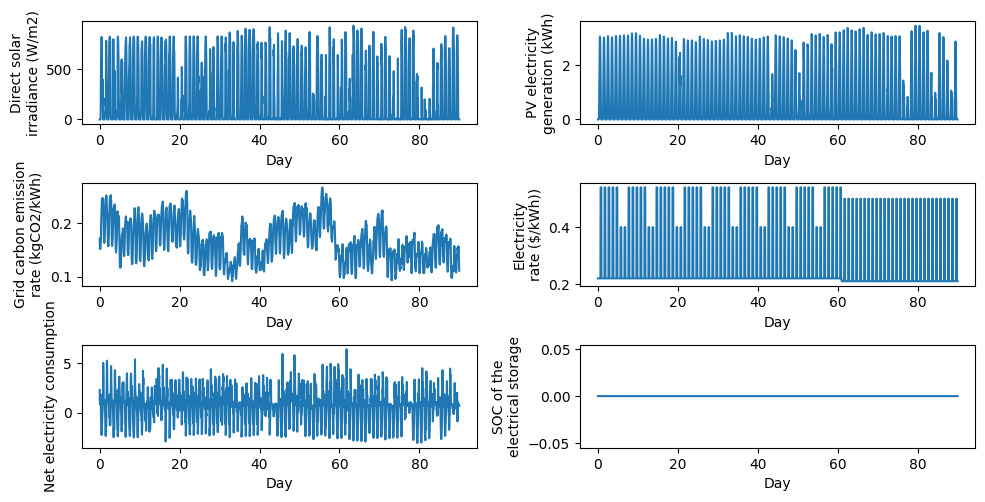

In [114]:
# Plot some of the observation values

fig, ax = plt.subplots(3, 2, figsize=(10, 5))
timestamps = np.arange(0, (n_timesteps+0.95)/24, 1/24)

# Plot direct solar irradiance (this has a strong influence on electricity generation)
i = np.where([x=="direct_solar_irradiance" for x in obs_names[0]])[0][0]
ax[0][0].plot(timestamps, [x[0][i] for x in obs])
ax[0][0].set_xlabel("Day")
ax[0][0].set_ylabel("Direct solar\nirradiance (W/m2)")

# Plot electricity generation from solar panels (when this is greater, it may be beneficial to charge the battery more)
i = np.where([x=="solar_generation" for x in obs_names[0]])[0][0]
ax[0][1].plot(timestamps, [x[0][i] for x in obs])
ax[0][1].set_xlabel("Day")
ax[0][1].set_ylabel("PV electricity\ngeneration (kWh)")

# Plot carbon intensity of the grid (when this is higher, it may be beneficial to discharge the battery more)
i = np.where([x=="carbon_intensity" for x in obs_names[0]])[0][0]
ax[1][0].plot(timestamps, [x[0][i] for x in obs])
ax[1][0].set_xlabel("Day")
ax[1][0].set_ylabel("Grid carbon emission\nrate (kgCO2/kWh)")

# Plot grid electricity price (when this is higher, it may be beneficial to discharge the battery more)
i = np.where([x=="electricity_pricing" for x in obs_names[0]])[0][0]
ax[1][1].plot(timestamps, [x[0][i] for x in obs])
ax[1][1].set_xlabel("Day")
ax[1][1].set_ylabel("Electricity\nrate ($/kWh))")

# Plot electricity consumption (when this is higher, the actions have a stronger influence on reward)
i = np.where([x=="net_electricity_consumption" for x in obs_names[0]])[0][0]
ax[2][0].plot(timestamps, [x[0][i] for x in obs])
ax[2][0].set_xlabel("Day")
ax[2][0].set_ylabel("Net electricity consumption")

# Plot state of battery charge (this should be constantly 0 for this agent)
i = np.where([x=="electrical_storage_soc" for x in obs_names[0]])[0][0]
ax[2][1].plot(timestamps, [x[0][i] for x in obs])
ax[2][1].set_xlabel("Day")
ax[2][1].set_ylabel("SOC of the\nelectrical storage")

plt.tight_layout()
plt.show()

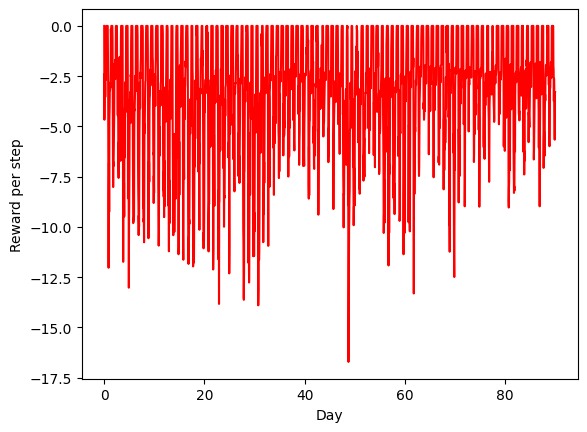

In [115]:
# Plot the reward
plt.plot(timestamps, rewards, 'r')
plt.xlabel("Day")
plt.ylabel("Reward per step")
plt.show()

The grid carbon emission rate varies substantially over the course of the three months, which is something to bear in mind: such fluctuations will not be seen if a model is trained only on a few days or weeks of data. The SOC of the electrical storage is entirely dependent on the agent's actions: if the agent only takes action 0, the SOC is always 0.

How much do these trends vary on a daily cycle?

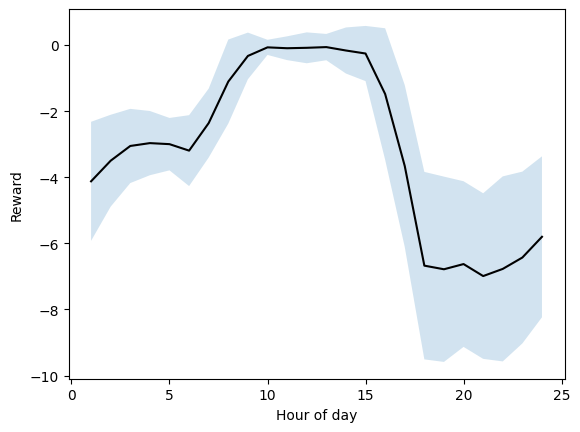

In [116]:
# Plot hourly average reward
mean_reward = np.zeros((24, ))
std_reward = np.zeros((24, ))
hours = [x for x in range(1, 25)]

for t in hours:
    
    time_idx = np.where([x[0][2]==t for x in obs])[0]
    mean_reward[t-1] = np.mean([rewards[x] for x in time_idx])
    std_reward[t-1] = np.std([rewards[x] for x in time_idx])
    
plt.fill_between(hours, mean_reward-std_reward, mean_reward+std_reward, alpha=0.2)
plt.plot(hours, mean_reward, 'k')
plt.xlabel("Hour of day")
plt.ylabel("Reward")
plt.show()

The constant-0 approach usually works well during peak daylight (9am - 3pm), but is worse during the rest of the day and particularly variable in the evening, which is perhaps when human electricity demand is also most variable.

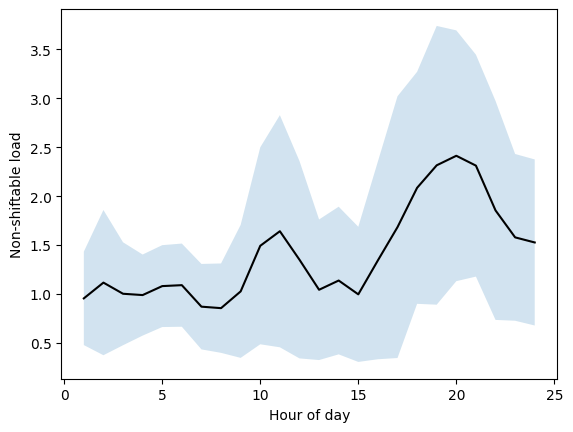

In [117]:
# Plot hourly average load
mean_load = np.zeros((24, ))
std_load = np.zeros((24, ))
hours = [x for x in range(1, 25)]

i = np.where([x=="non_shiftable_load" for x in obs_names[0]])[0][0]
load = [x[0][i] for x in obs]

for t in hours:
    
    time_idx = np.where([x[0][2]==t for x in obs])[0]
    mean_load[t-1] = np.mean([load[x] for x in time_idx])
    std_load[t-1] = np.std([load[x] for x in time_idx])
    
plt.fill_between(hours, mean_load-std_load, mean_load+std_load, alpha=0.2)
plt.plot(hours, mean_load, 'k')
plt.xlabel("Hour of day")
plt.ylabel("Non-shiftable load")
plt.show()

Indeed, although the average non-shiftable load is very variable throughout the day, it is more so in the evening hours, around 8pm, when the constant-0 approach yields the most variable reward. This is useful as it gives insight into what the most important factors are.

# Baseline 2: random agent
Now, CityLearn's inbuilt random agent to compare.

In [118]:
from citylearn.agents.rbc import HourRBC

# Reset environment
observation = env.reset()

# Initialise random agent
random_agent = HourRBC(env=env)

# Initialise variables to store observations and rewards
obs = [observation]
random_rewards = [0]

# Iterate over n_timesteps timesteps, taking a random action each time
done = False
while not done:
  actions = random_agent.predict(observation, deterministic=True)
  observation, r, done, info = env.step(actions)
  random_rewards.append(r[0])

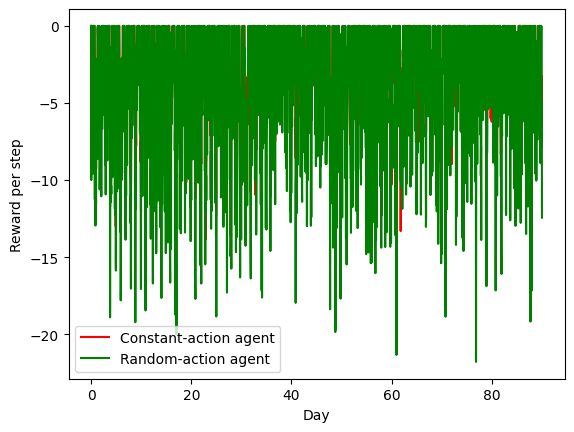

In [119]:
# Plot the reward
plt.plot(timestamps, rewards, 'r')
plt.plot(timestamps, random_rewards, 'g')
plt.xlabel("Day")
plt.ylabel("Reward per step")
plt.legend(labels=["Constant-action agent", "Random-action agent"])
plt.show()

Random actions generate more variable returns than a constant action, and although this is not explicitly a KPI, it is undesirable in a reinforcement learning agent generally and for this task in particular because it would produce unpredictable grid loads and energy costs.

In [120]:
# Evaluate the agent
kpis = random_agent.env.evaluate()
kpis.head(15)

,cost_function,value,name,level
0,annual_peak_average,1.303824,District,district
1,carbon_emissions_total,1.749339,District,district
2,cost_total,1.684067,District,district
3,daily_one_minus_load_factor_average,1.045088,District,district
4,daily_peak_average,1.580079,District,district
5,discomfort_delta_average,0.000000,District,district
6,discomfort_delta_maximum,0.000000,District,district
7,discomfort_delta_minimum,0.000000,District,district
8,discomfort_proportion,NaN,District,district
9,discomfort_too_cold_proportion,NaN,District,district


In [121]:
# Create a function to get a score
def get_score(agent):

  # Evaluate agent
  kpis = random_agent.env.evaluate()

  # Calculate score from relevant KPIs
  Centry = kpis["value"].loc[(kpis["cost_function"]=="cost") & (kpis["name"]=="District")]
  Gentry = kpis["value"].loc[(kpis["cost_function"]=="carbon_emissions") & (kpis["name"]=="District")]
  score = Centry + Gentry

  return score

In [122]:
# Print results for constant-action and random-action agents
constant_agent_cumulative_reward = sum(rewards)
random_agent_reward_cumulative_reward = sum(random_rewards)
print(f"Cumulative reward over 3 months with constant action 0 is {constant_agent_cumulative_reward:.2f}")
print(f"Cumulative reward over 3 months with random actions is {random_agent_reward_cumulative_reward:.2f}")

Cumulative reward over 3 months with constant action 0 is -6808.73
Cumulative reward over 3 months with random actions is -8710.59


# Baseline 3: rule-based agent
CityLearn provides a rule-based agent whose rules have been optimised by a grid search, that takes actions based on just one input: the time of day.

In [123]:
from citylearn.agents.rbc import OptimizedRBC

# Reset environment
observation = env.reset()

# Initialise rule-based agent
rule_based_agent = OptimizedRBC(env=env)

# Initialise variables to store observations and rewards
obs = [observation]
rule_based_rewards = [0]

# Iterate over n_timesteps timesteps
done = False
while not done:
  actions = rule_based_agent.predict(observation, deterministic=True)
  observation, r, done, info = env.step(actions)
  rule_based_rewards.append(r[0])

In [132]:
# Print results for constant-action, random-action and rule-based agents
constant_agent_cumulative_reward = sum(rewards)
random_agent_reward_cumulative_reward = sum(random_rewards)
rule_based_agent_reward_cumulative_reward = sum(rule_based_rewards)
print(f"Cumulative reward over 3 months with constant action 0 is {constant_agent_cumulative_reward:.2f}")
print(f"Cumulative reward over 3 months with random actions is {random_agent_reward_cumulative_reward:.2f}")
print(f"Cumulative reward over 3 months with rule-based actions is {rule_based_agent_reward_cumulative_reward:.2f}")

Cumulative reward over 3 months with constant action 0 is -6808.73
Cumulative reward over 3 months with random actions is -8710.59
Cumulative reward over 3 months with rule-based actions is -7417.60


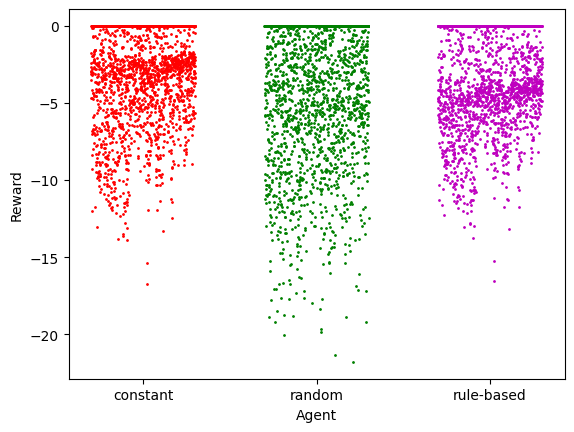

In [134]:
# Plot comparison of all three agents as swarm plots

fix, ax = plt.subplots(1, 1)
x_jitter = np.linspace(-0.3, 0.3, len(rewards))
ax.scatter(x_jitter+1, rewards, 1, 'r')
ax.scatter(x_jitter+2, random_rewards, 1, 'g')
ax.scatter(x_jitter+3, rule_based_rewards, 1, 'm')
ax.set_xticks([1, 2, 3], labels=["constant", "random", "rule-based"])
ax.set_xlabel("Agent")
ax.set_ylabel("Reward")
plt.show()

# Summary

Presented here are three non-machine-learning-based solutions to the reinforcement learning problem. The constant and random agents are highly simplistic, with the constant-action agent introduced here performing better than CityLearn's random agent, in the sense of producing less variable rewards over the 3 months evaluated here. That makes it a better baseline to serve as the lower bound of what a reinforcement learning agent should achieve.

The optimised rule-based agent provided by CityLearn, which chooses its actions based on the time of day, surprisingly performs comparably to the constant-action agent despite the time of day correlating reasonably well with some of the other observation features like solar radiation, temperature and non-shiftable load. This confirms that the problem does not have an easy solution and machine learning methods will be needed to improve on this.